#### Imports

In [81]:
import re
import pandas as pd
import itertools
from io import StringIO
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import zipfile
import time
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import linregress

DATA_ROOT = Path("../data/discord")

SECTION_TITLES = [
    "Accounts and Servers: Warnings & Temporary Interventions",
    "Accounts Disabled",
    "Servers Removed",
    "Appeals",
    "Reports",
    "NCMEC",
    "US Gov Info Requests",
    "International Government Information Requests",
    "Preservation Requests",
    "Emergency Requests"
]

MONTHS = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

#### Utils

In [82]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # drop unnamed or fully empty columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df = df.dropna(axis=1, how="all")

    # clean columns
    df.columns = [c.strip() for c in df.columns]

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(",", "", regex=False)
            df[col] = df[col].replace({"--": None, "nan": None, "": None})
            # numeric conversion
            try:
                df[col] = pd.to_numeric(df[col])
            except (ValueError, TypeError):
                # else leave as original string
                pass

    return df

def extract_report_period_from_name(path: Path) -> str:
    name = path.name

    # Match full or abbreviated month ranges with connectors and year
    pattern = (
        r'\b('
        r'(?:[A-Za-z]{3,9})'                # First month (e.g., Jan or January)
        r'(?:\s*[_\-\u2013–to]+\s*)'        # Separator: underscore, dash, en-dash, or "to"
        r'(?:[A-Za-z]{3,9})'                # Second month (e.g., Jun or June)
        r'\s*20\d{2}'                       # Year
        r')\b'
    )
    m = re.search(pattern, name, flags=re.IGNORECASE)
    if m:
        # Normalize spacing and connectors
        period = re.sub(r'[_\u2013–]+', '-', m.group(1))
        period = re.sub(r'\s*-\s*', ' - ', period)
        return period.strip().title()

    # Fallback: match single month + year
    m = re.search(r'\b([A-Za-z]{3,9}\s*20\d{2})\b', name)
    if m:
        return m.group(1).strip().title()

    # Fallback: year only
    m = re.search(r'(20\d{2})', name)
    return m.group(1) if m else name

def parse_report_csv(file_path):
    # read and clean lines
    with open(file_path, "r", encoding="utf-8-sig") as f:
        lines = [line.strip() for line in f if line.strip() != ""]

    section_indices = {}
    for i, line in enumerate(lines):
        clean_line = re.sub(r",+$", "", line).strip()
        if clean_line in SECTION_TITLES:
            section_indices[clean_line] = i

    ordered_sections = sorted(section_indices.items(), key=lambda x: x[1])

    sections_data = {}
    for idx, (title, start_idx) in enumerate(ordered_sections):
        end_idx = ordered_sections[idx + 1][1] if idx + 1 < len(ordered_sections) else len(lines)
        block = lines[start_idx + 1:end_idx]
        block = [l for l in block if l.strip(",")]
        if not block:
            continue
        try:
            df = pd.read_csv(StringIO("\n".join(block)))
            df = clean_dataframe(df)
            sections_data[title] = df
        except Exception as e:
            print(f"Could not parse section {title}: {e}")

    # # preview
    # for name, df in sections_data.items():
    #     print(f"\n=== {name} ===")
    #     print(df.head())

    return sections_data


def _period_sort_key(period: str):
    """Return (year, start_month) tuple for sorting period strings."""
    if not isinstance(period, str):
        return (0, 0)
    # extract year
    y_m = re.search(r'(20\d{2})', period)
    year = int(y_m.group(1)) if y_m else 0
    # find first month name in the string
    month_names = re.findall(r'([A-Za-z]{3,9})', period)
    start_month = 0
    for m in month_names:
        key = m[:3].lower()
        if key in MONTHS:
            start_month = MONTHS[key]
            break
    return (year, start_month)

# helper: parse period string -> start Timestamp
def period_start_ts(period_str):
    m_year = re.search(r'(20\d{2})', str(period_str))
    year = int(m_year.group(1)) if m_year else 1970
    month_names = re.findall(r'([A-Za-z]{3,9})', str(period_str))
    month = 1
    for m in month_names:
        key = m[:3].lower()
        if key in MONTHS:
            month = MONTHS[key]
            break
    return pd.Timestamp(year=year, month=month, day=1)


In [83]:
def load_all_reports(data_root: Path) -> pd.DataFrame:
    """Iterate all report folders and aggregate into one master DataFrame (sorted by period)."""
    records = []
    for folder in sorted(data_root.glob("Discord-Transparency-*")):
        for csv_path in folder.glob("*.csv"):
            period = extract_report_period_from_name(csv_path)
            print(f"Processing period: {period}")
            section_data = parse_report_csv(csv_path)
            records.append({"period": period, "dataframes": section_data})

    df = pd.DataFrame(records)
    if not df.empty:
        df["_sort_key"] = df["period"].apply(_period_sort_key)
        df = df.sort_values(by="_sort_key", ascending=True).reset_index(drop=True)
        df = df.drop(columns=["_sort_key"])
    return df

In [37]:
def build_all_periods_df_from_master(master_df):
    """
    Convert master_df (period, dataframes dict) into a long dataframe with one row per period x policy_category.
    It will try to extract 'Servers Removed' and 'Reports' tables and merge them.
    All numeric columns are coerced to integers where possible.
    """
    rows = []
    for _, row in master_df.iterrows():
        period = row['period']
        dfs = row.get('dataframes') or {}
        sr = dfs.get('Servers Removed')
        reps = dfs.get('Reports')

        if sr is None:
            continue

        # normalize column names
        sr = sr.rename(columns=lambda c: str(c).strip())
        # detect key columns
        cat_col = sr.columns[0]
        pro_cols = [c for c in sr.columns if 'proactiv' in c.lower()]
        rea_cols = [c for c in sr.columns if 'reactiv' in c.lower()]
        total_cols = [c for c in sr.columns if 'total' in c.lower() or 'total servers' in c.lower()]

        # pick first candidate or fallback to positional columns
        pro_col = pro_cols[0] if pro_cols else (sr.columns[1] if sr.shape[1] > 1 else None)
        rea_col = rea_cols[0] if rea_cols else (sr.columns[2] if sr.shape[1] > 2 else None)
        total_col = total_cols[0] if total_cols else None

        def to_num(val):
            if pd.isna(val):
                return np.nan
            v = str(val).strip().replace('"', '').replace("'", "")
            v = v.replace(',', '')
            try:
                return pd.to_numeric(v, errors='coerce')
            except Exception:
                return np.nan

        # prepare reports table lookup
        if reps is not None:
            reps = reps.rename(columns=lambda c: str(c).strip())

        for _, r in sr.iterrows():
            cat = str(r.get(cat_col, '')).strip()
            if not cat or cat.lower().startswith('total') or cat.lower().startswith('sum'):
                continue

            proactive = to_num(r.get(pro_col)) if pro_col is not None else np.nan
            reactive = to_num(r.get(rea_col)) if rea_col is not None else np.nan

            # determine servers_removed: prefer explicit total column, else sum proactive+reactive, else try any numeric column
            if total_col is not None:
                servers_removed = to_num(r.get(total_col))
            else:
                if not pd.isna(proactive) or not pd.isna(reactive):
                    p = 0 if pd.isna(proactive) else proactive
                    q = 0 if pd.isna(reactive) else reactive
                    servers_removed = p + q
                else:
                    found = np.nan
                    for c in sr.columns[1:]:
                        val = to_num(r.get(c))
                        if not pd.isna(val):
                            found = val
                            break
                    servers_removed = found

            # find matching reports entry if available
            reports_count = None
            if reps is not None and reps.shape[1] >= 2:
                rep_num_cols = [c for c in reps.columns if pd.api.types.is_numeric_dtype(reps[c]) or reps[c].astype(str).str.replace(',','').str.isnumeric().any()]
                if not rep_num_cols:
                    rep_num_cols = [reps.columns[1]]
                try:
                    matches = reps.iloc[:,0].astype(str).str.strip().str.lower() == cat.lower()
                    if matches.any():
                        rep_val = reps.loc[matches, rep_num_cols[0]].iloc[0]
                        reports_count = to_num(rep_val)
                except Exception:
                    reports_count = None

            rows.append({
                'period': period,
                'policy_category': cat,
                'servers_removed': servers_removed,
                'proactive': proactive,
                'reactive': reactive,
                # 'reports': reports_count
                'proactive_share': proactive / servers_removed,
                'reactive_share': reactive / servers_removed
            })

    all_df = pd.DataFrame(rows)
    all_df['policy_category'] = all_df['policy_category'].astype(str).str.strip()

    # assign chronological integer IDs to each period using _period_sort_key
    # sorted_periods will be in chronological order (earliest -> latest)
    unique_periods = all_df['period'].astype(str).unique().tolist()
    sorted_periods = sorted(unique_periods, key=_period_sort_key)
    period_id_map = {p: i + 1 for i, p in enumerate(sorted_periods)}  # start IDs at 1
    all_df['period_id'] = all_df['period'].map(period_id_map).astype('Int64')

    numeric_cols = ['servers_removed', 'proactive', 'reactive', 'reports']
    for col in numeric_cols:
        if col in all_df.columns:
            all_df[col] = pd.to_numeric(all_df[col], errors='coerce').astype('Int64')  # nullable integer type

    return all_df


### Load master frame

In [84]:
master_df = load_all_reports(DATA_ROOT)

all_servers_removed = {
    row.period: row.dataframes.get("Servers Removed")
    for _, row in master_df.iterrows()
    if "Servers Removed" in row.dataframes
}

# print(all_servers_removed["April - June 2022"])

Processing period: January - June 2024
Processing period: January - March 2022
Processing period: January - March 2023
Processing period: April - June 2022
Processing period: April - June 2023
Processing period: July - September 2022
Processing period: July - September 2023
Processing period: October - December 2023


## SUBQ1: Proactive vs reactive server-level enforcement

### Aggregated server shutdown plot

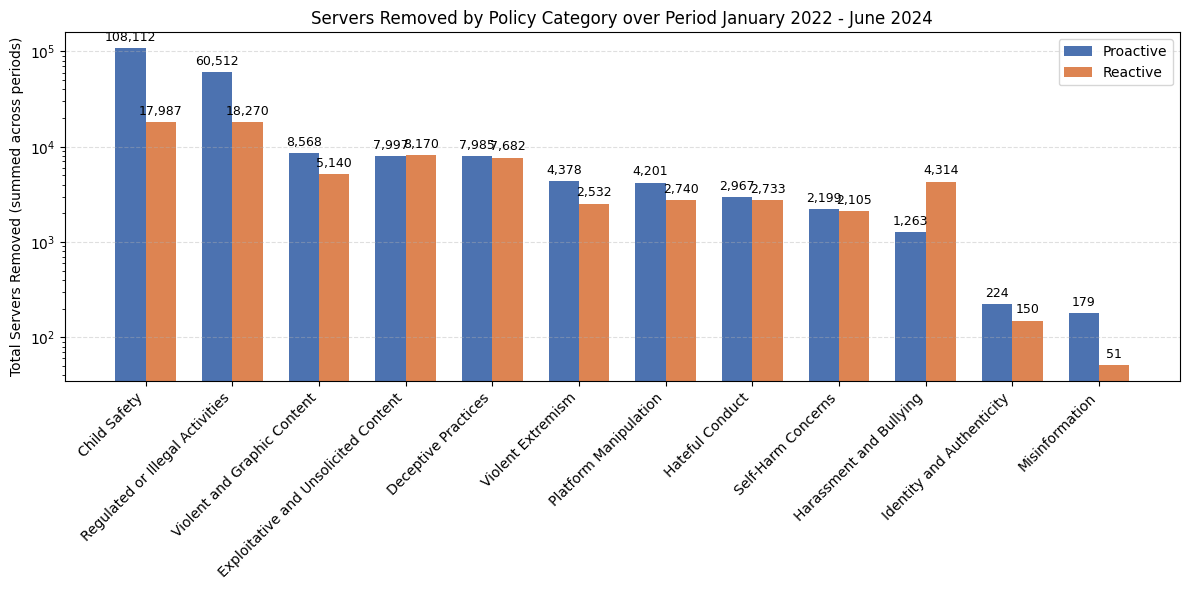

In [80]:
def aggregate_servers_removed(all_servers_removed: dict):
    rows = []
    for period, df in all_servers_removed.items():
        if df is None or getattr(df, "empty", True):
            continue
        d = df.copy()
        d.columns = [c.strip() for c in d.columns]

        # detect column names
        cat_col = next((c for c in d.columns if "category" in c.lower()), None)
        pro_col = next((c for c in d.columns if "proactive" in c.lower()), None)
        rea_col = next((c for c in d.columns if "reactive" in c.lower()), None)
        if not (cat_col and pro_col and rea_col):
            # skip if expected columns not found
            continue

        d = d[[cat_col, pro_col, rea_col]].copy()
        # clean numbers
        d[pro_col] = pd.to_numeric(d[pro_col].astype(str).str.replace(",", ""), errors="coerce").fillna(0).astype(int)
        d[rea_col] = pd.to_numeric(d[rea_col].astype(str).str.replace(",", ""), errors="coerce").fillna(0).astype(int)
        d[cat_col] = d[cat_col].astype(str)
        # drop totals/summary rows
        d = d[~d[cat_col].str.contains("total", case=False, na=False)]
        d["period"] = period

        rows.append(d.rename(columns={cat_col: "category", pro_col: "proactive", rea_col: "reactive"}))

    if not rows:
        return pd.DataFrame(columns=["category", "proactive", "reactive"]), pd.DataFrame()

    all_df = pd.concat(rows, ignore_index=True, sort=False)
    # aggregate by category summing over periods
    agg = all_df.groupby("category", as_index=False)[["proactive", "reactive"]].sum()
    return agg, all_df

agg_df, all_rows_df = aggregate_servers_removed(all_servers_removed)

# plot grouped bar chart (two bars per category)
if not agg_df.empty:
    agg_df = agg_df.sort_values(by=["proactive", "reactive"], ascending=False).reset_index(drop=True)
    cats = agg_df["category"].tolist()
    proactive = agg_df["proactive"].values
    reactive = agg_df["reactive"].values

    x = np.arange(len(cats))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    b1 = ax.bar(x - width/2, proactive, width, label="Proactive", color="#4C72B0")
    b2 = ax.bar(x + width/2, reactive, width, label="Reactive", color="#DD8452")

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Total Servers Removed (summed across periods)")
    ax.set_title("Servers Removed by Policy Category over Period January 2022 - June 2024")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # annotate
    def annotate(bars):
        for bar in bars:
            h = int(bar.get_height())
            ax.annotate(f"{h:,}",
                        xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)

    annotate(b1)
    annotate(b2)

    plt.tight_layout()
    plt.show()
else:
    print("No Servers Removed data found to aggregate.")

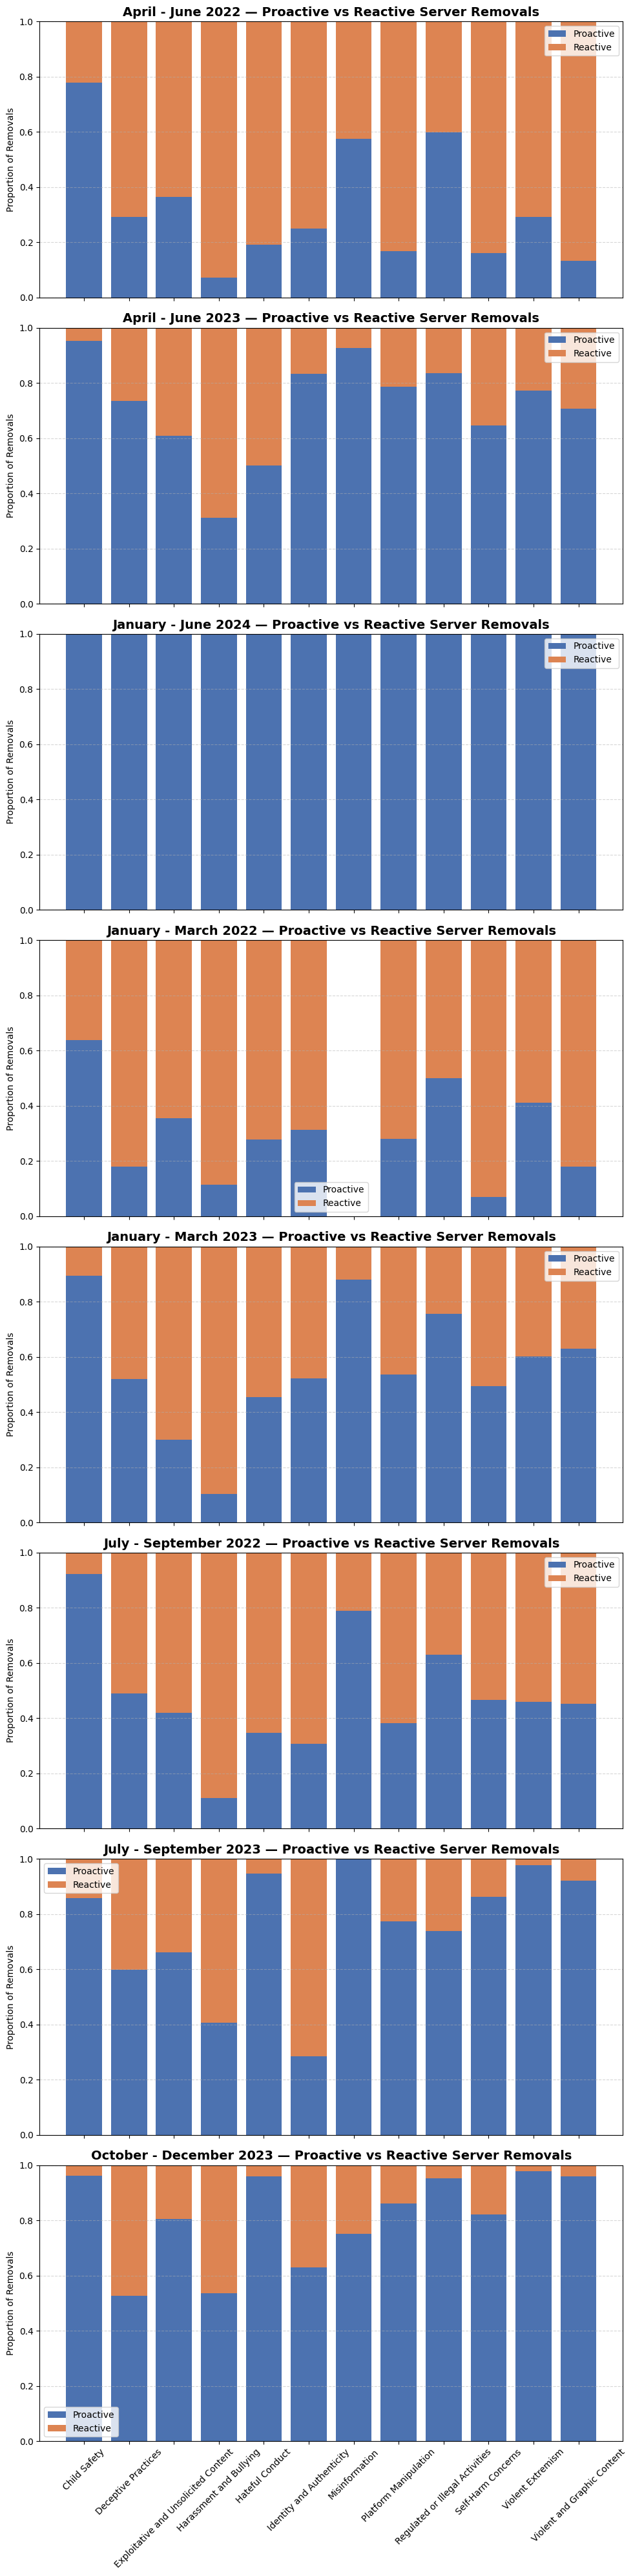

In [71]:
def plot_proactive_reactive_stacked(df):
    """
    Create stacked bar charts per period showing proactive vs reactive proportions per policy category.
    """
    # Ensure numeric
    df[['proactive', 'reactive']] = df[['proactive', 'reactive']].apply(pd.to_numeric, errors='coerce')

    # Aggregate if necessary (in case of duplicate period/category)
    df = df.groupby(['period', 'policy_category'], as_index=False)[['proactive', 'reactive']].sum()

    # Compute total and proportions
    df['total'] = df['proactive'] + df['reactive']
    df['proactive_prop'] = df['proactive'] / df['total']
    df['reactive_prop'] = df['reactive'] / df['total']

    # Sort by policy_category for consistency
    df = df.sort_values(['period', 'policy_category'])

    periods = df['period'].unique()
    n_periods = len(periods)

    fig, axes = plt.subplots(n_periods, 1, figsize=(10, 5 * n_periods), sharex=True)

    if n_periods == 1:
        axes = [axes]

    for ax, period in zip(axes, periods):
        sub = df[df['period'] == period].sort_values('policy_category')
        x = sub['policy_category']

        ax.bar(x, sub['proactive_prop'], label='Proactive', color='#4C72B0')
        ax.bar(x, sub['reactive_prop'], bottom=sub['proactive_prop'], label='Reactive', color='#DD8452')

        ax.set_title(f"{period} — Proactive vs Reactive Server Removals", fontsize=14, weight='bold')
        ax.set_ylabel("Proportion of Removals")
        ax.set_ylim(0, 1)
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    
plot_proactive_reactive_stacked(all_periods_df)


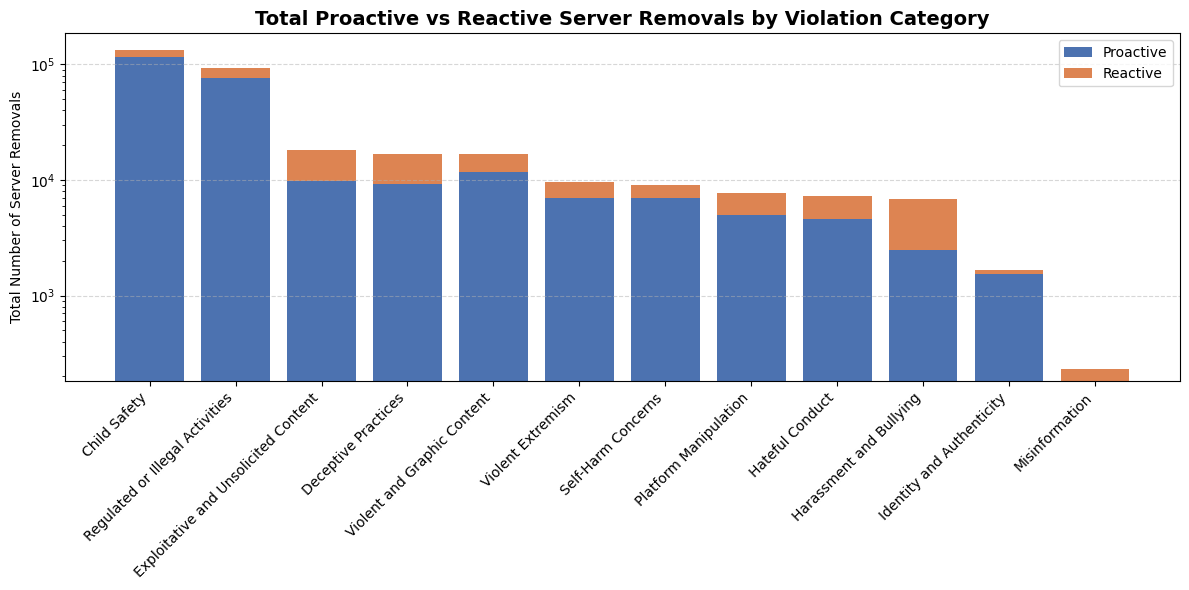

In [74]:
def plot_total_proactive_reactive(df):
    """
    Plot a single stacked bar chart showing the total proactive vs reactive removals per policy category,
    aggregated across all periods.
    """
    # Ensure numeric
    df[['proactive', 'reactive']] = df[['proactive', 'reactive']].apply(pd.to_numeric, errors='coerce')

    # Aggregate across all periods by category
    agg_df = df.groupby('policy_category', as_index=False)[['proactive', 'reactive']].sum()

    # Compute proportions (optional, for annotation or scaling)
    agg_df['total'] = agg_df['proactive'] + agg_df['reactive']
    agg_df['proactive_prop'] = agg_df['proactive'] / agg_df['total']
    agg_df['reactive_prop'] = agg_df['reactive'] / agg_df['total']

    # Sort by total or alphabetically (optional)
    agg_df = agg_df.sort_values('total', ascending=False)

    # Plot stacked bar
    plt.figure(figsize=(12, 6))
    x = agg_df['policy_category']
    plt.bar(x, agg_df['proactive'], label='Proactive', color='#4C72B0')
    plt.bar(x, agg_df['reactive'], bottom=agg_df['proactive'], label='Reactive', color='#DD8452')

    # Labels & formatting
    plt.title("Total Proactive vs Reactive Server Removals by Violation Category", fontsize=14, weight='bold')
    plt.ylabel("Total Number of Server Removals")
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_total_proactive_reactive(all_periods_df)


## SUBQ2:

In [42]:
all_periods_df = build_all_periods_df_from_master(master_df)

all_periods_df.head()

,period,policy_category,servers_removed,proactive,reactive,proactive_share,reactive_share,period_id
0,January - March 2022,Child Safety,24706,15788,8918,0.639035,0.360965,1
1,January - March 2022,Deceptive Practices,1797,322,1475,0.179188,0.820812,1
2,January - March 2022,Exploitative and Unsolicited Content,3525,1248,2277,0.354043,0.645957,1
3,January - March 2022,Harassment and Bullying,716,82,634,0.114525,0.885475,1
4,January - March 2022,Hateful Conduct,965,268,697,0.277720,0.722280,1


/var/folders/69/6nn2sm8d7qq0p98t_qgp1ckr0000gn/T/ipykernel_65208/1721881888.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  events = pd.to_datetime(event_strs, dayfirst=True, errors='coerce')


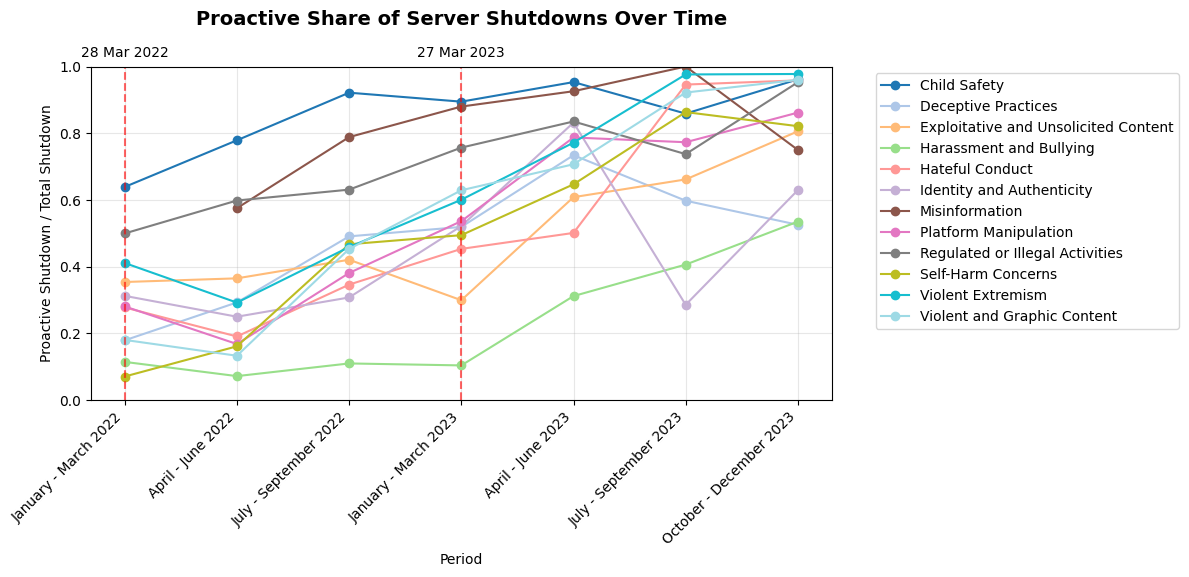

In [69]:
df = all_periods_df[all_periods_df["period"] != "January - June 2024"]
pivot_df = df.pivot(index='period_id', columns='policy_category', values='proactive_share')

plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('tab20', len(pivot_df.columns))  # or 'tab20b', 'tab20c', 'viridis', etc.

for i, col in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col, color=cmap(i))

# map period_id -> original period string (preserve chronological order)
id_to_label = (all_periods_df[['period_id', 'period']]
               .drop_duplicates(subset=['period_id'])
               .set_index('period_id')['period']
               .to_dict())

# build mapping period_id -> start Timestamp
period_dates = {int(pid): period_start_ts(lbl) for pid, lbl in id_to_label.items()}

# event dates (your list) -> parse with dayfirst=True
event_strs = ["7 may 2020", "28 march 2022", "27 march 2023", "15 april 2024", "29 sept 2025"]
events = pd.to_datetime(event_strs, dayfirst=True, errors='coerce')

# plot vertical lines only for events inside the timeline
sorted_pids = sorted(period_dates.keys())
for ev, ev_raw in zip(events, event_strs):
    if pd.isna(ev):
        continue
    # skip events outside overall range
    first = period_dates[sorted_pids[0]]
    last = period_dates[sorted_pids[-1]] #+ pd.DateOffset(months=6)  # allow last period span
    if not (first <= ev < last):
        continue
    # find period_id where event falls: period_start <= ev < next_period_start
    x_pos = None
    for i, pid in enumerate(sorted_pids):
        start = period_dates[pid]
        end = period_dates[sorted_pids[i+1]] if i + 1 < len(sorted_pids) else start + pd.DateOffset(months=6)
        if start <= ev < end:
            x_pos = pid
            break
    if x_pos is None:
        continue
    plt.axvline(x=x_pos, color='r', linestyle='--', alpha=0.6)
    plt.text(x_pos, 1.02, ev.strftime('%d %b %Y'), va='bottom', ha='center', transform=plt.gca().get_xaxis_transform())

# build labels for the x ticks in the same order as pivot_df.index
x_labels = [id_to_label.get(int(pid), str(pid)) for pid in pivot_df.index]

plt.title("Proactive Share of Server Shutdowns Over Time", fontsize=14, weight='bold', y=1.1)
plt.xlabel("Period")
plt.ylabel("Proactive Shutdown / Total Shutdown")
plt.ylim(0, 1)
plt.xticks(ticks=pivot_df.index, labels=x_labels, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### OLS on timeseries

In [70]:
trend_results = []
for cat, sub in df.groupby('policy_category'):
    # Encode period order numerically
    sub = sub.sort_values('period')
    x = np.arange(len(sub))
    y = sub['proactive_share']
    if len(x) > 1 and y.notna().all():
        slope, intercept, r, p, _ = linregress(x, y)
        trend_results.append({
            'policy_category': cat,
            'slope': slope,
            'r_value': r,
            'p_value': p
        })

trend_df = pd.DataFrame(trend_results)
print(trend_df.sort_values('slope', ascending=False))


                         policy_category     slope   r_value   p_value
4                        Hateful Conduct  0.116473  0.812315  0.026418
11           Violent and Graphic Content  0.113720  0.743656  0.055349
9                     Self-Harm Concerns  0.100330  0.711460  0.072998
10                     Violent Extremism  0.089727  0.706025  0.076238
7                  Platform Manipulation  0.076900  0.606741  0.148574
3                Harassment and Bullying  0.056202  0.666369  0.102149
2   Exploitative and Unsolicited Content  0.053411  0.606199  0.149036
8        Regulated or Illegal Activities  0.035679  0.503922  0.248862
6                         Misinformation  0.028685  0.357015  0.487230
1                    Deceptive Practices  0.026324  0.305649  0.505009
0                           Child Safety  0.022918  0.430328  0.335172
5              Identity and Authenticity  0.001487  0.014629  0.975168
